In [1]:
import datasets
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW, get_cosine_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import pickle
import random
import os
import numpy as np
import pandas as pd
import plotly.express as px

COLAB = False

In [2]:
if COLAB:
    # make a connection with my google drive
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if COLAB:
    %cd drive/MyDrive/python_project/BERTforQA/
    !pip install datasets==1.11.0
    !pip install transformers==4.5.0

In [4]:
# load dataset concatanated by 'train' and 'validation'
train_dataset = datasets.load_dataset('squad', split='train')
test_dataset = datasets.load_dataset('squad', split='validation') 
dataset = datasets.concatenate_datasets([train_dataset, test_dataset])


# Using automatic mixed precision training (fp16)
fp16_training = True
if fp16_training:
    if COLAB:
        !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# load pretrained model and tokenizer
model = BertForQuestionAnswering.from_pretrained('bert-base-cased').to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Reusing dataset squad (/Users/hau/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
Reusing dataset squad (/Users/hau/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
/Users/hau/miniconda3/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:111: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if 

In [5]:
# The answer of some cases don't exist in their context.
def check_target_exist(input_ids, target_tokenized):
    check_list = []
    for i in range(0, (len(input_ids)-len(target_tokenized)+1)):
        window = input_ids[i:i+len(target_tokenized)]
        if window == target_tokenized:
            check_list.append('V')
    return 'V' in check_list

clean_case = [i for i in tqdm(range(0, len(dataset))) 
                    if check_target_exist(tokenizer.encode(dataset[i]['context'], add_special_tokens=False),
                                          tokenizer.encode(dataset[i]['answers']['text'][0], add_special_tokens=False))]

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


In [6]:
# split dataset into train_dataset, dev_dataset, test_dataset with size of 8:1:1
clean_dataset = dataset.select(clean_case)
dataset = clean_dataset.train_test_split(test_size = 0.1)
train_dev_dataset = dataset['train']
train_dev_dataset = train_dev_dataset.train_test_split(test_size = 0.111)
train_dataset, dev_dataset, test_dataset = train_dev_dataset['train'], train_dev_dataset['test'], dataset['test']



Loading cached split indices for dataset at /Users/hau/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-127d06e1bee64585.arrow and /Users/hau/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-96d995cbf09c2034.arrow


In [7]:
# Tokenize questions and paragraphs separately
train_questions_tokenized = tokenizer([case['question'] for case in tqdm(train_dataset)], add_special_tokens=False)
dev_questions_tokenized = tokenizer([case['question'] for case in tqdm(dev_dataset)], add_special_tokens=False)
test_questions_tokenized = tokenizer([case['question'] for case in tqdm(test_dataset)], add_special_tokens=False)

train_paragraphs_tokenized = tokenizer([case['context'] for case in tqdm(train_dataset)], add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer([case['context'] for case in tqdm(dev_dataset)], add_special_tokens=False)
test_paragraphs_tokenized = tokenizer([case['context'] for case in tqdm(test_dataset)], add_special_tokens=False)

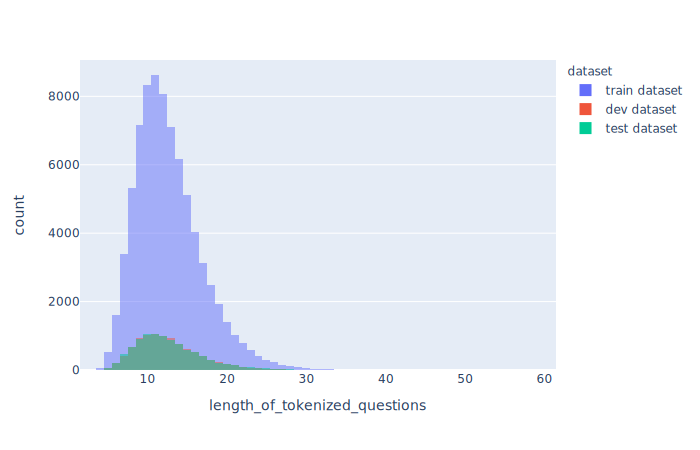

In [8]:
# histogram of tokenized questions
x0 = np.array([len(x) for x in train_questions_tokenized['input_ids']])
x1 = np.array([len(x) for x in dev_questions_tokenized['input_ids']])
x2 = np.array([len(x) for x in test_questions_tokenized['input_ids']])

df = pd.DataFrame(dict(
    dataset = np.concatenate((["train dataset"]*len(x0), ["dev dataset"]*len(x1), ["test dataset"]*len(x2))), 
    length_of_tokenized_questions = np.concatenate((x0,x1,x2))
))

fig1 = px.histogram(df, x="length_of_tokenized_questions", color="dataset", barmode="overlay")
fig1.show("svg")

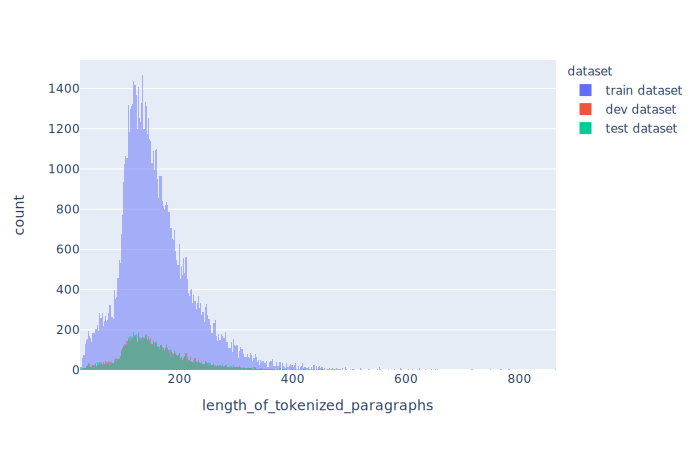

In [9]:
# histogram of tokenized paragraphs
x0 = np.array([len(x) for x in train_paragraphs_tokenized['input_ids']])
x1 = np.array([len(x) for x in dev_paragraphs_tokenized['input_ids']])
x2 = np.array([len(x) for x in test_paragraphs_tokenized['input_ids']])

df =pd.DataFrame(dict(
    dataset = np.concatenate((["train dataset"]*len(x0), ["dev dataset"]*len(x1), ["test dataset"]*len(x2))), 
    length_of_tokenized_paragraphs = np.concatenate((x0,x1,x2))
))

fig2 = px.histogram(df, x="length_of_tokenized_paragraphs", color="dataset", barmode="overlay")
fig2.show("svg")

In [10]:
class QA_Dataset(Dataset):
    def __init__(self, split, tokenizer, dataset, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.tokenized_questions = tokenized_questions['input_ids']
        self.tokenized_paragraphs = tokenized_paragraphs['input_ids']
        self.max_question_len = 30
        self.max_paragraph_len = 250
        self.doc_stride = 150
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

        
    def __len__(self):
        return len(self.dataset)

    
    def padding(self, input_ids_question, input_ids_paragraph):
        # pad zero such that every sequence of length is max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        input_ids = input_ids_question + input_ids_paragraph + [0]* padding_len
        token_type_ids = [0]* len(input_ids_question) + [1]* len(input_ids_paragraph) + [0]* padding_len
        attention_mask = [1]* (len(input_ids_question) + len(input_ids_paragraph)) + [0]* padding_len
        return input_ids, token_type_ids, attention_mask
    
    
    def locate_start_end_target_token(self, input_ids, target_tokenized):
        # locate the indice of target start token and target end token
        window_size = len(target_tokenized)
        target_window = []
        for i in range(0, len(input_ids)-window_size+1):
            search_window = input_ids[i: i+window_size]
            if search_window == target_tokenized:
                target_window.append((i, i+window_size-1))
        target_start_token, target_end_token = target_window[0][0], target_window[0][1]
        return target_start_token, target_end_token
    
    
    def check_target_exist(self, input_ids, target_tokenized):
        check_list = []
        for i in range(0, (len(input_ids)-len(target_tokenized)+1)):
            if input_ids[i:i+len(target_tokenized)] == target_tokenized:
                check_list.append('V')
        return 'V' in check_list

    
    def __getitem__(self, index):
        question = self.dataset[index]
        tokenized_question = self.tokenized_questions[index]
        tokenized_paragraph = self.tokenized_paragraphs[index]
        answer = question['answers']['text'][0]
        answer_tokenized = self.tokenizer.encode(answer, add_special_tokens=False) # add_special_tokens=False means that embedding without [CLS] & [SEP]

        if self.split == 'train':
            # output "designated window", which contain answer token
            windows = []
            for i in range(0, max(1, len(tokenized_paragraph)-self.max_paragraph_len+1)):
                windows.append(tokenized_paragraph[i:i+self.max_paragraph_len])
            windows_contain_answer = [x for x in windows if self.check_target_exist(x, answer_tokenized)]
            random.seed(index)
            designated_window = windows_contain_answer[random.randint(0, len(windows_contain_answer)-1)]
            
            # add special tokens ([CLS]->[101], [SEP]->[102]) to tokenized_question
            # add special tokens ([SEP]->[102]) to tokenized_paragraph
            input_ids_question = [101] + tokenized_question[0:self.max_question_len] + [102]
            input_ids_paragraph = designated_window + [102]
            
            # padding zero such that every sequence is equal to "self.max_seq_len"
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            answer_start_token, answer_end_token = self.locate_start_end_target_token(input_ids, answer_tokenized)
            
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []
            
            # Paragraph is split into several windows, which length of every window is "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):
                
                # add special tokens ([CLS]->[101], [SEP]->[102]) to tokenized_question
                # add special tokens ([SEP]->[102]) to tokenized_paragraph
                input_ids_question = [101] + tokenized_question[0:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph[i: i + self.max_paragraph_len] + [102]
                
                # padding zero such that every sequence is equal to "self.max_seq_len"
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
                
                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)
            
            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)



train_set = QA_Dataset("train", tokenizer, train_dataset, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", tokenizer, dev_dataset, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", tokenizer, test_dataset, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 16

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)


In [11]:
# Obtain the answer

def evaluate(data, output):    
    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    
    for k in range(num_of_windows):
        # Obtain the index by maximum logits in 'start_logits' & 'end_logits'
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob
        
        # Replace answer if calculated probability is larger than previous window
        if prob > max_prob:
            max_prob = prob
            
            # exchange start_index and end_index if start_index > end_index
            # Is it reasonable? (TODO)
            if start_index > end_index:
                start_index, end_index = end_index, start_index
            
            # Convert tokens to chars
            # ex: [16416, 1158, 1104, 1103, 5568, 2813] --> 'partitioning of the Ottoman Empire'
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])
    
    return answer

In [ ]:
# Training Model

num_epoch = 10
validation = True
logging_step = 100
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=30, num_training_steps=len(train_loader))


if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader) 

model.train()

print("Start Training ...")

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0
    
    for data in tqdm(train_loader):
        # Load all data into GPU
        data = [i.to(device) for i in data]
        
        # Model inputs: input_ids, token_type_ids, attention_mask, start_index, end_index
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)  
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
        # output.start_logits = output.end_logits = (batch_size, sequence_length)
        start_index = torch.argmax(output.start_logits, dim=1)
        end_index = torch.argmax(output.end_logits, dim=1)
        
        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss
        
        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        step += 1

        
        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                # prediction is correct only if answer text exactly matches
                dev_acc += evaluate(data, output) == dev_dataset[i]['answers']['text'][0]
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()
        
    scheduler.step()

'''save fine-tuned model using pickle
   saved model can be re-loaded using { model = pickle.load(open('saved_model/model.pkl', 'rb')) }'''

print('Saving Model ...')
os.mkdir('saved_model')
pickle.dump(model, open('saved_model/model.pkl', 'wb'))

